# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
import pyspark
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql.functions import udf,max,avg,col,when
from pyspark.sql.types import IntegerType

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StandardScaler, StringIndexer, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("appname")\
    .config("config option","config value")\
    .getOrCreate()

spark.sparkContext.getConf().getAll()

[('spark.app.id', 'local-1590507251536'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('config option', 'config value'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.port', '44437'),
 ('spark.app.name', 'appname'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.driver.host', 'eb17ef755063')]

# Load and Clean Dataset

All the processes are perform on the mini_sparkify_event_data.json data

### 1. Load the Dataset

In [3]:
path = "mini_sparkify_event_data.json"
spd = spark.read.json(path)

### 2. Inspect the data 

In [4]:
df = spd.toPandas()
df.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286500 entries, 0 to 286499
Data columns (total 18 columns):
artist           228108 non-null object
auth             286500 non-null object
firstName        278154 non-null object
gender           278154 non-null object
itemInSession    286500 non-null int64
lastName         278154 non-null object
length           228108 non-null float64
level            286500 non-null object
location         278154 non-null object
method           286500 non-null object
page             286500 non-null object
registration     278154 non-null float64
sessionId        286500 non-null int64
song             228108 non-null object
status           286500 non-null int64
ts               286500 non-null int64
userAgent        278154 non-null object
userId           286500 non-null object
dtypes: float64(2), int64(4), object(12)
memory usage: 39.3+ MB


### 3. Check and clean null values

In [6]:
df.isnull().sum()

artist           58392
auth                 0
firstName         8346
gender            8346
itemInSession        0
lastName          8346
length           58392
level                0
location          8346
method               0
page                 0
registration      8346
sessionId            0
song             58392
status               0
ts                   0
userAgent         8346
userId               0
dtype: int64

In [7]:
df.describe()

,itemInSession,length,registration,sessionId,status,ts
count,286500.000000,228108.000000,2.781540e+05,286500.000000,286500.000000,2.865000e+05
mean,114.414213,249.117182,1.535359e+12,1041.526555,210.054597,1.540957e+12
std,129.767262,99.235179,3.291322e+09,726.776263,31.505078,1.507544e+09
min,0.000000,0.783220,1.521381e+12,1.000000,200.000000,1.538352e+12
25%,27.000000,199.888530,1.533522e+12,336.000000,200.000000,1.539697e+12
50%,70.000000,234.500770,1.536664e+12,1013.000000,200.000000,1.540932e+12
75%,156.250000,277.158730,1.537672e+12,1675.000000,200.000000,1.542266e+12
max,1321.000000,3024.665670,1.543247e+12,2474.000000,404.000000,1.543799e+12


In [8]:
spd = spd.filter(spd["userId"] != "")
spd.count()

278154

# Exploratory Data Analysis

### Define Churn

Churn is an activity log event called Cancellation Confirmation which happen for both paid and free users, therefore a user is churned is when there is a churn log.

### Explore Data

Exploratory data analysis is performed to observe the behavior for users who stayed vs users who churned.

- Churn Count by Gender
- Churn Count by Level
- Churn vs Average_Songs_Played

In [9]:
#Checking the type of Pages
spd.select("page").dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [10]:
#Churn is defined as the users who got to 'Cancellation Confirmation'. Also 'Downgrade' event is being tracked. 
churn_flag = udf(lambda x:1 if x=="Cancellation Confirmation" else 0, IntegerType())
spd = spd.withColumn("churn_flag",churn_flag("page"))


# label Churned users (if Churned once)
windowval = Window.partitionBy('userId')
spd = spd.withColumn('churn', max('churn_flag').over(windowval))


#Downgrade Event
down_flag = udf(lambda x:1 if x=="Submit Downgrade" else 0, IntegerType())
spd = spd.withColumn("Downgrade_flag", down_flag("page"))


# label Downgraded users (if Downgraded  once)
windowval = Window.partitionBy('userId')
spd = spd.withColumn('Downgraded', max('Downgrade_flag').over(windowval))

#Drop the flag columns (no longer needed)
columns_to_drop = ['churn_flag', 'Downgrade_flag']
spd = spd.drop(*columns_to_drop)

In [11]:
spd.head(1)

[Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', churn=0, Downgraded=0)]

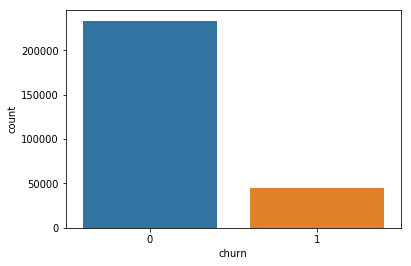

In [12]:
churn_count = spd.select(['churn']).toPandas()
sns.countplot(churn_count['churn']);

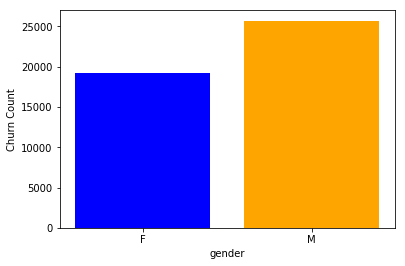

In [13]:
def plot_df_churns(groupField):
    plot_df = spd.groupby(groupField).agg({'churn':'sum'}).toPandas()
    
    #plotting
    plt.bar(x=plot_df[groupField],height=plot_df['sum(churn)'],color=['blue','orange'])
    plt.xlabel(groupField)
    plt.ylabel("Churn Count")
    plt.show()
    
#Users Churn by Gender
plot_df_churns('gender')

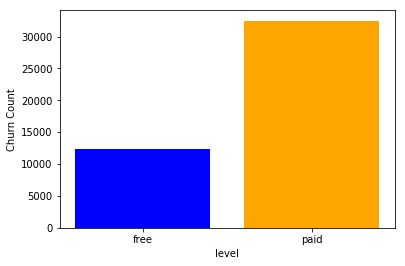

In [14]:
#Users churn by Level
plot_df_churns('level')

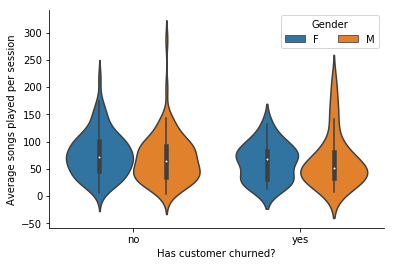

In [15]:
songs_pd = spd.where('page == "NextSong"').groupby(['churn', 'userId', 'sessionId','gender']).count()\
    .groupby(['churn', 'userId', 'gender']).agg({'count':'avg'})\
    .withColumnRenamed('avg(count)', 'avg_songs_played')\
    .toPandas()

Value_map = {1:'yes', 0:'no'}
songs_pd['churn'] = songs_pd['churn'].map(Value_map)

ax = sns.violinplot('churn', y='avg_songs_played', hue='gender', data=songs_pd)
plt.xlabel('Has customer churned?')
plt.ylabel('Average songs played per session')
plt.legend(title='Gender', loc='best', ncol=2)
sns.despine(ax=ax);

# Feature Engineering

Features Engineered (below):
- Gender
- Level
- Number of Songs played by user
- Number of Artists user has listened to
- Session Counts and Downgrade Event

In [16]:
#First obvious features would be Gender and Level, apart from downgrade event

#gender
gender = spd.select("userId", "gender").dropDuplicates()
gender = gender.replace(["M", "F"], ["0", "1"], "gender")
gender = gender.select("userId", gender.gender.cast("int"))

gender.show(5)

#level
level = spd.select("userId", "level").dropDuplicates()
level = level.replace(["free", "paid"], ["0", "1"], "level")
level = level.select("userId", level.level.cast("int"))

level.show(5)

#users downgrade
downgrade = spd.select("userId", "Downgraded").dropDuplicates()
downgrade = downgrade.select("userId", downgrade.Downgraded.cast("int"))

downgrade.show(5)

+------+------+
|userId|gender|
+------+------+
|    44|     1|
|    46|     1|
|    41|     1|
|    72|     1|
|300023|     1|
+------+------+
only showing top 5 rows

+------+-----+
|userId|level|
+------+-----+
|100021|    0|
|200021|    0|
|200001|    0|
|     6|    0|
|300022|    1|
+------+-----+
only showing top 5 rows

+------+----------+
|userId|Downgraded|
+------+----------+
|100010|         0|
|200002|         0|
|   125|         0|
|   124|         0|
|    51|         0|
+------+----------+
only showing top 5 rows



In [17]:
#Number of Song Played as a feature 
song_played = spd.where(spd.song!='null').groupby('userId') \
    .agg({'song':'count'}).orderBy('userId') \
    .select(['userId','count(song)'])
song_played.withColumnRenamed("count(song)", "songCount")
song_played.show()

+------+-----------+
|userId|count(song)|
+------+-----------+
|    10|        673|
|   100|       2682|
|100001|        133|
|100002|        195|
|100003|         51|
|100004|        942|
|100005|        154|
|100006|         26|
|100007|        423|
|100008|        772|
|100009|        518|
|100010|        275|
|100011|         11|
|100012|        476|
|100013|       1131|
|100014|        257|
|100015|        800|
|100016|        530|
|100017|         52|
|100018|       1002|
+------+-----------+
only showing top 20 rows



In [18]:
#Number of Singers user has listened to 
singers_count = spd.dropDuplicates(['userId','artist']).groupby('userId') \
    .agg({'artist':'count'}).orderBy('userId') \
    .select(['userId','count(artist)'])
singers_count.withColumnRenamed("count(artist)", "artistCount")
singers_count.show()

+------+-------------+
|userId|count(artist)|
+------+-------------+
|    10|          565|
|   100|         1705|
|100001|          125|
|100002|          184|
|100003|           50|
|100004|          733|
|100005|          149|
|100006|           26|
|100007|          357|
|100008|          623|
|100009|          442|
|100010|          252|
|100011|           11|
|100012|          397|
|100013|          826|
|100014|          233|
|100015|          627|
|100016|          431|
|100017|           51|
|100018|          780|
+------+-------------+
only showing top 20 rows



In [19]:
#number of sessions 
session_count = spd.select("userId", "sessionId").dropDuplicates().groupby("userId").count()
session_count = session_count.withColumnRenamed("count", "sessionCount")

session_count.show(5)

+------+------------+
|userId|sessionCount|
+------+------------+
|100010|           7|
|200002|           6|
|   125|           1|
|    51|          10|
|   124|          29|
+------+------------+
only showing top 5 rows



In [20]:
#combine features & label
spd_modelFeatures = spd.dropDuplicates(['userId']).sort('userId').select(['userId','churn'])
for feature in [gender, level, downgrade, singers_count, session_count, song_played]:
    spd_modelFeatures = spd_modelFeatures.join(feature,'userId')

spd_modelFeatures = spd_modelFeatures.withColumnRenamed("count(song)", "songCount").withColumnRenamed(\
                                                        "count(artist)", "artistCount")

spd_modelFeatures.show(5)

+------+-----+------+-----+----------+-----------+------------+---------+
|userId|churn|gender|level|Downgraded|artistCount|sessionCount|songCount|
+------+-----+------+-----+----------+-----------+------------+---------+
|100010|    0|     1|    0|         0|        252|           7|      275|
|200002|    0|     0|    0|         0|        339|           6|      387|
|200002|    0|     0|    1|         0|        339|           6|      387|
|   125|    1|     0|    0|         0|          8|           1|        8|
|   124|    0|     1|    1|         0|       2232|          29|     4079|
+------+-----+------+-----+----------+-----------+------------+---------+
only showing top 5 rows



# Modeling

### 1. Building Pipeline

In [21]:
#Defining Transformers for Pipeline 
assembler = VectorAssembler(inputCols=spd_modelFeatures.columns[2:],outputCol='featureVector')
scaler = StandardScaler(inputCol="featureVector", outputCol="features", withStd=True)
indexer = StringIndexer(inputCol="churn", outputCol="label")

#### Logistic Regression Model

In [22]:
#Logistic Regression Model 
lr =  LogisticRegression(labelCol="label", featuresCol="features", maxIter=10, regParam=0.0, elasticNetParam=0)

#defining Pipeline
pipeline = Pipeline(stages=[assembler, scaler, indexer, lr])

#Parameter grid
param = ParamGridBuilder() \
    .addGrid(lr.regParam,[0.0, 0.001, 0.01, 0.1]) \
    .build()

#set evaluator -'one time needed'
evaluator = MulticlassClassificationEvaluator(metricName='f1')

#cross-validation
lr_crossval = CrossValidator(estimator=pipeline, estimatorParamMaps=param, 
                             evaluator=evaluator, numFolds=3)

#### RandomForest Model

In [23]:
#Random forest
rf = RandomForestClassifier(numTrees=20, maxDepth=2, labelCol="label", seed=42)

#defining Pipeline
pipeline = Pipeline(stages=[assembler, scaler, indexer, rf])

#Parameter grid
param = ParamGridBuilder() \
    .addGrid(rf.numTrees,[20, 50]).addGrid(rf.maxDepth,[2,3, 5]) \
    .build()


#cross-validation
rf_crossval = CrossValidator(estimator=pipeline, estimatorParamMaps=param, 
                             evaluator=evaluator, numFolds=3)

#### SVM

In [24]:
svm = LinearSVC(labelCol="label", featuresCol="features",maxIter=10)

#defining Pipeline
pipeline = Pipeline(stages=[assembler, scaler, indexer, svm])

#Parameter grid
param = ParamGridBuilder() \
    .build()


#cross-validation
svm_crossval = CrossValidator(estimator=pipeline, estimatorParamMaps=param, 
                              evaluator=evaluator, numFolds=3)

#### Train and Test set

In [25]:
#split data 
train, test = spd_modelFeatures.randomSplit([0.7, 0.3], seed=42)

#### Evaluating the models

In [26]:
def evaluation(model,modelname):
    """
    Input:
      model- model for evaluation 
      modelname - string representing the name of the model used
    Return:
      None
    """
    #training
    cv = model.fit(train)
    #evaluation
    print(modelname)
    print("\nTraining Metrics: ",cv.avgMetrics)
    # test performance
    predictions = cv.transform(test)
    print("\nTest Metric 'F1-Score': ",MulticlassClassificationEvaluator().setMetricName("f1").evaluate(predictions))
    return cv

In [27]:
cv_lr = evaluation(lr_crossval, "Logistic Regression")

Logistic Regression

Training Metrics:  [0.677020916214381, 0.677020916214381, 0.677020916214381, 0.677020916214381]

Test Metric 'F1-Score':  0.6670274170274171


In [28]:
cv_rf = evaluation(rf_crossval, "Random Forest Classifier")

Random Forest Classifier

Training Metrics:  [0.677020916214381, 0.677020916214381, 0.699794572561548, 0.677020916214381, 0.6813014121756918, 0.7063673866589948]

Test Metric 'F1-Score':  0.7069970845481051


In [29]:
cv_svm = evaluation(svm_crossval, "SVM Classifier")

SVM Classifier

Training Metrics:  [0.677020916214381]

Test Metric 'F1-Score':  0.6670274170274171


## Conclusion
 
We implemented a model trying to predict customer churn. We removed rows with no userId, converted gender and level to binary numeric column. 6 features were engineered for our model. We selected 3 models: logistic regression, Random Forest & SVM based on our Knowledge. We used cross validation and grid search to fine tune our model. We achieved '0.71' as F1 score for our model with Random Forest. We also used it to drive the important features that may have led to Customer churn. By identifying customer with high churn chance companies can target and retain them with attractive offers/incentives. Also, this project gave a good exposure to spark environment to analyze a large volume of data. for improve this project I would suggest the addition of more features, and the implementation of a UI.
